In [1]:
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np

from neurolib.models.wc import WCModel
import neurolib.utils.loadData as ld
import neurolib.utils.functions as func

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

In [2]:
mat = scipy.io.loadmat('Consensus_Connectomes.mat',simplify_cells=True,squeeze_me=True,chars_as_strings=True)
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'LauConsensus'])


In [3]:
print(mat['LauConsensus'].keys())

dict_keys(['Matrices', 'Readme'])


In [4]:
print(mat['LauConsensus']['Readme'])

['1 - weighted adj mat' '2 - fiber length mat' '3 - fc mat'
 '4 - coordinates' '5{1} - roi name' '5{2} - short name' '5{3} - rsn name'
 '5{4} - hemisphere']


In [5]:
print(mat['LauConsensus']['Matrices'].shape)

(5, 5)


In [6]:
print(mat['LauConsensus']['Matrices'][2].shape)

(5,)


In [7]:
print(mat['LauConsensus']['Matrices'][2][0].shape) # SC
print(mat['LauConsensus']['Matrices'][2][1].shape) # delays
print(mat['LauConsensus']['Matrices'][2][2].shape) # FC

(219, 219)
(219, 219)
(219, 219)


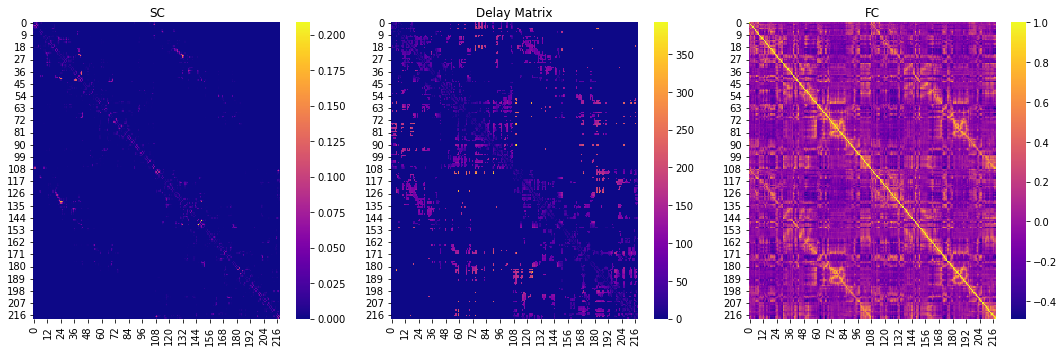

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(mat['LauConsensus']['Matrices'][2][0], ax=axes[0], cmap="plasma")
axes[0].set_title("SC")

sns.heatmap(mat['LauConsensus']['Matrices'][2][1], ax=axes[1], cmap="plasma")
axes[1].set_title("Delay Matrix")

sns.heatmap(mat['LauConsensus']['Matrices'][2][2], ax=axes[2], cmap="plasma")
axes[2].set_title("FC")

plt.tight_layout()
plt.show()

In [12]:
# model = WCModel(Cmat = mat['LauConsensus']['Matrices'][2][0], Dmat = mat['LauConsensus']['Matrices'][2][1])

def normalize_matrix(matrix):
    min_in_matrix = float('inf')
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i][j] < min_in_matrix:
                min_in_matrix = matrix[i][j]
    
    matrix = matrix - min_in_matrix
    
    max_in_matrix = float('-inf')
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i][j] > max_in_matrix:
                max_in_matrix = matrix[i][j]
                # print("found max", max_in_matrix)
    result = matrix / max_in_matrix
    print("normalize check", np.min(result), np.max(result))
    return result

model = WCModel(Cmat = normalize_matrix(mat['LauConsensus']['Matrices'][2][0]), Dmat = mat['LauConsensus']['Matrices'][2][1])

normalize check 0.0 1.0


In [13]:
normalize_matrix(np.array([[1,2,3], [4,5,6], [7,8,9]]))

normalize check 0.0 1.0


array([[0.   , 0.125, 0.25 ],
       [0.375, 0.5  , 0.625],
       [0.75 , 0.875, 1.   ]])

In [14]:
model.params['exc_ext'] = 0.65

model.params['signalV'] = 0
model.params['duration'] = 20 * 1000 
model.params['sigma_ou'] = 0.14
model.params['K_gl'] = 3.15


model.run(chunkwise=True)

(0.0, 200.0)

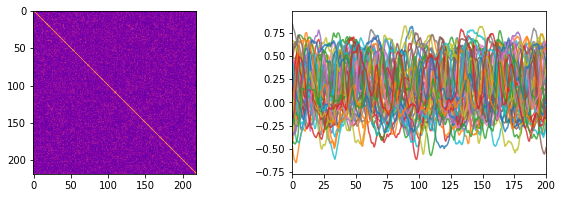

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].imshow(func.fc(model.exc[:, -10000:]))
axs[1].plot(model.t, model.exc[::5, :].T, alpha=0.8);
axs[1].set_xlim(0, 200)

In [16]:
func.fc(model.exc[:, -10000:]).shape

(219, 219)

In [17]:
score = func.matrix_correlation(func.fc(model.exc[:, -10000:]), mat['LauConsensus']['Matrices'][2][2])
print("Mean FC/FC correlation: {:.2f}".format(score))

Mean FC/FC correlation: 0.04


## Looping through parameters

In [24]:
max_corr = float('-inf')
max_params = {}
for exc_ext in np.arange(0.0, 1.0, 0.2):
    for signalV in np.arange(0.0, 1.0, 0.2):
        for sigma_ou in np.arange(0.0, 1.0, 0.2):
            for K_gl in np.arange(0.0, 5.0, 0.5):
                model.params['exc_ext'] = exc_ext
                model.params['signalV'] = signalV
                model.params['duration'] = 20 * 1000
                model.params['sigma_ou'] = sigma_ou
                model.params['K_gl'] = K_gl
                model.run(chunkwise=True)
                
                score = func.matrix_correlation(func.fc(model.exc[:, -10000:]), mat['LauConsensus']['Matrices'][2][2])
                print("current FC/FC correlation: {:.2f}".format(score))
                if score > max_corr:
                    max_corr = score
                    max_params['exc_ext'] = exc_ext
                    max_params['signalV'] = signalV
                    max_params['duration'] = 20 * 1000
                    max_params['sigma_ou'] = sigma_ou
                    max_params['K_gl'] = K_gl
                    print("Max found, max: {0}, params: {1}".format(max_corr, max_params))

SystemError: CPUDispatcher(<function timeIntegration_njit_elementwise at 0x7fe52a0a4310>) returned a result with an error set

Max found, max: {0}, params: {1} 0.01919055916674434 {'exc_ext': 0.0, 'signalV': 0.1, 'duration': 20000, 'sigma_ou': 0.9, 'K_gl': 1.2000000000000002}

Max found, max: 0.04679743129711301, params: {'exc_ext': 0.0, 'signalV': 0.0, 'duration': 20000, 'sigma_ou': 0.0, 'K_gl': 1.5}